Importing Libraries

In [1]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import urlparse
import re 
import numpy as np

import seaborn as sns


Scraping through fiteq.org and merging the dataframes into one

In [3]:
## CREATE THE EVENTS DATABASE AND THEN THE LIST WITH THE URLS
url_events = "https://api.fiteq.org/v1/event"

In [4]:
r_events = requests.get(url_events)

In [5]:
soup_events = BeautifulSoup(r_events.content, 'html.parser')

In [6]:
data_events = json.loads(soup_events.text)

In [7]:
df_events = pd.DataFrame.from_dict(data_events['past'])


In [8]:
events_list = df_events['id'].to_list()

In [9]:
events_name = df_events['name'].to_list()

In [11]:
## Build URLs for each tournament
url_base = 'https://api.fiteq.org/v1/event/matches/'

In [12]:
urltexts = []

for url in events_list:
    urltexts.append(url_base + str(url))
    
print(urltexts[0:5])

['https://api.fiteq.org/v1/event/matches/4', 'https://api.fiteq.org/v1/event/matches/14', 'https://api.fiteq.org/v1/event/matches/15', 'https://api.fiteq.org/v1/event/matches/19', 'https://api.fiteq.org/v1/event/matches/20']


In [13]:
urls = []
for text in urltexts:
    urls.append(urlparse(text).geturl())
    

print(len(urls))


181


In [15]:
## NOW WE HAVE THE URLS for all competitions. Read in now all databases from the API
df = pd.DataFrame()

In [16]:
for url, event_name in zip(urls, events_name):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    data = json.loads(soup.text)
    dataframe = pd.DataFrame(data['results'])
    dataframe['event_name'] = str(event_name)

    
    df = df.append(dataframe)

<ipython-input-16-cea64d545b31>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataframe)
<ipython-input-16-cea64d545b31>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataframe)
<ipython-input-16-cea64d545b31>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataframe)
<ipython-input-16-cea64d545b31>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataframe)
<ipython-input-16-cea64d545b31>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataframe)
<ipython-input-16-ce

Cleaning the big DataFrame

In [17]:
## Use only the necessary columns
df1 = df[['event_name', 'type', 'playerAName', 'associationPlayer_A', 'playerBName', 'associationPlayer_B', 'playerXName', 'associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'stage', 'scoreSets', 'matchDateTime', 'setsWon_A', 'setsWon_X', 'pointTotal_A', 'pointTotal_X']]

In [19]:
## Extracting the scores to set scores
scores_list =[]
df1 = df1[(df1['pointTotal_A'] + df1['pointTotal_X']) != 0].reset_index(drop=True)
df1 = df1[df1.scoreSets.str.len() != 0].reset_index(drop=True)

set1_AB = []
set1_XY = []

set2_AB = []
set2_XY = []

set3_AB = []
set3_XY = []

In [20]:

for i in range(len(df1['scoreSets'])):
    if len(df1.scoreSets[i]) == 3:
        set1_AB.append(df1.scoreSets[i][0]['a'])
        set1_XY.append(df1.scoreSets[i][0]['x'])

        set2_AB.append(df1.scoreSets[i][1]['a'])
        set2_XY.append(df1.scoreSets[i][1]['x'])

        set3_AB.append(df1.scoreSets[i][2]['a'])
        set3_XY.append(df1.scoreSets[i][2]['x'])

    elif len(df1.scoreSets[i]) == 2:
        set1_AB.append(df1.scoreSets[i][0]['a'])
        set1_XY.append(df1.scoreSets[i][0]['x'])

        set2_AB.append(df1.scoreSets[i][1]['a'])
        set2_XY.append(df1.scoreSets[i][1]['x'])

        set3_AB.append(0)
        set3_XY.append(0)

    else:
        set1_AB.append(df1.scoreSets[i][0]['a'])
        set1_XY.append(df1.scoreSets[i][0]['x'])
        
        set2_AB.append(0)
        set2_XY.append(0)

        set3_AB.append(0)
        set3_XY.append(0);

In [21]:
len(set1_AB) == len(set1_XY) == len(set2_AB) == len(set2_XY) == len(set3_AB) == len(set3_XY) ## quick check

True

In [22]:
## Columns we need:
 ## Event Name, Category, Player A, Association Player A, Player B, Association Player B, Player X, Association Player X, Player Y, Association Player Y, 
 # Stage, Set 1 AB, Set 1 XY, Set 2 AB, Set 2 XY, Set 3 AB, Set 3 XY, Match Date, Sets Won AB, Sets Won XY, Points total AB, Points total XY, Winner, Loser

In [23]:
## Just in case - make sure to have the first letters capital and the rest are small

df1['playerAName'] = df1['playerAName'].apply(lambda x: x.title())
df1['playerBName'] = df1['playerBName'].apply(lambda x: x.title())
df1['playerXName'] = df1['playerXName'].apply(lambda x: x.title())
df1['playerYName'] = df1['playerYName'].apply(lambda x: x.title())

In [24]:
## Add scores to columns
df1['set1_AB'] = set1_AB
df1['set1_XY'] = set1_XY
df1['set2_AB'] = set2_AB
df1['set2_XY'] = set2_XY
df1['set3_AB'] = set3_AB
df1['set3_XY'] = set3_XY
df1.drop('scoreSets', axis = 1, inplace = True)


In [25]:
## Quick cleaning with the strings & numbers to integers

df1.replace(np.nan, "", inplace = True )
df1.replace("NaN", "", inplace = True)
df1['setsWon_A'] = df1['setsWon_A'].apply(lambda x: int(float(x)))
df1['setsWon_X'] = df1['setsWon_X'].apply(lambda x: int(float(x)))
df1['pointTotal_A'] = df1['pointTotal_A'].apply(lambda x: int(float(x)))
df1['pointTotal_X'] = df1['pointTotal_X'].apply(lambda x: int(float(x)))


In [26]:
## Empty strings to 0s and then strings to integers for future calculations
df1['set2_AB'].replace('', 0, inplace = True)
df1['set2_XY'].replace('', 0, inplace = True)
df1['set3_AB'].replace('', 0, inplace = True)
df1['set3_XY'].replace('', 0, inplace = True)


In [27]:
df1['set2_AB']= df1['set2_AB'].apply(lambda x: int(float(x)))
df1['set2_XY']= df1['set2_XY'].apply(lambda x: int(float(x)))
df1['set3_AB']= df1['set3_AB'].apply(lambda x: int(float(x)))
df1['set3_XY']= df1['set3_XY'].apply(lambda x: int(float(x)))

In [28]:
## NaN to empty strings in players names
df1.loc[:, 'playerAName': 'playerYName'].replace(np.nan, "", inplace = True)

Making alphabetical changes to make sure that "Jim Rohn & Gary Smith" is the same doubles as "Gary Smith & Jim Rohn"

In [29]:
idx = (df1['playerAName'] > df1['playerBName']) & (df1['playerBName'] != "")
idy = (df1['playerXName'] > df1['playerYName']) & (df1['playerYName'] != "")

In [30]:
df1.loc[idx,['playerAName', 'associationPlayer_A','playerBName', 'associationPlayer_B']] = df1.loc[idx,['playerBName', 'associationPlayer_B','playerAName', 'associationPlayer_A']].values
df1.loc[idy,['playerXName', 'associationPlayer_X','playerYName', 'associationPlayer_Y']] = df1.loc[idy,['playerYName', 'associationPlayer_Y','playerXName', 'associationPlayer_X']].values

In [31]:
df1.sample(15) ## Quick random check

,event_name,type,playerAName,associationPlayer_A,playerBName,associationPlayer_B,playerXName,associationPlayer_X,playerYName,associationPlayer_Y,...,setsWon_A,setsWon_X,pointTotal_A,pointTotal_X,set1_AB,set1_XY,set2_AB,set2_XY,set3_AB,set3_XY
4110,New Jersey Challenger Cup,DoublesFree,Brett Lorenzini,United States,Luka Pilic,Croatia,Denilson Olivera,Peru,Michael Silva,United States,...,2,0,24,12,12,6,12,6,0,0
6873,Sumeg Challenger Cup,DoublesFree,Hugo Rabeux,France,Julien Grondin,France,Apor Szocs,Romania,Janos Kis,Romania,...,2,0,24,13,12,8,12,5,0,0
10738,Teqball World Series - Paris,DoublesMen,Matej Kubovy,Czech Republic,Simon Novotny,Czech Republic,Andrija Jovanovic,Montenegro,Marko Zarkovic,Montenegro,...,2,0,24,17,12,11,12,6,0,0
2101,Polish Challenger Series - Round 1,DoublesMixed,Bartosz Januszewski,Poland,Klaudia Mindak,Poland,Ewa Kaminska,Poland,Patryk Kaminski,Poland,...,0,2,17,24,10,12,7,12,0,0
764,Xiamen Challenger Cup 2020,SinglesFree,Adam Blazsovics,Hungary,,,Edwar Nicolas Suarez Aranzales,Colombia,,,...,1,0,20,2,20,2,0,0,0,0
3497,Romanian Challenger Series - Round 3,DoublesFree,Apor Szocs,Romania,Janos Kis,Romania,Tamas Gergely,Romania,Tamas Kovacs,Romania,...,1,2,30,34,10,12,12,10,8,12
950,Dunaújváros Challenger Cup 2020,SinglesFree,Noel Lengyel,Hungary,,,Balazs Imreh,Hungary,,,...,0,1,11,20,11,20,0,0,0,0
8770,Hungarian Challenger Series - Round 4,DoublesMixed,Gabor Bajor,Hungary,Luca Horvath,Hungary,Evelin Eros,Hungary,Zoltan Pal,Hungary,...,2,0,24,11,12,4,12,7,0,0
6734,Canton All-Female Challenger Cup\t,DoublesWomen,Mami Yamaguchi,Japan,Margaret Osmundson,United States,Emily Eitzman,,Eve Davis,United States,...,2,0,24,10,12,2,12,8,0,0
1010,Los Angeles Challenger Cup 2020,DoublesFree,Brian Esler,United States,Carolyn Greco,United States,Dmytro Stasyshen,Ukraine,Michael Ruecktenwald,United States,...,0,2,15,24,10,12,5,12,0,0


Selecting only events with 12-point system (as previously it was 20 points - which may lead to abnormalities outcomes)

In [32]:
df1 = df1[df1['event_name'].apply(lambda x: x not in ['III. Warsaw Challenger Cup 2019', 'Novi Sad Challenger Cup 2019', 'II. Warsaw Challenger Cup 2019', 'Teqball Masters 2019', 'Budapest Challenger Cup 2019', 'Balassagyarmat Challenger Cup 2019', 'Asia-Pacific Beach Teqball Cup', 'African Beach Teqball Cup', 'Teqball World Championships 2019 '
, 'II. Balassagyarmat Challenger Cup 2019', 'Xiamen Challenger Cup 2020', 'Dunaújváros Challenger Cup 2020', 'Budapest Women Challenger Cup 2020', 'Teqball World Championships 2018', 'Warsaw Cup 2019','Chocen Challenger Cup 2020'])]

In [33]:
df1.reset_index(drop = True, inplace = True )

In [34]:
df1.head()

,event_name,type,playerAName,associationPlayer_A,playerBName,associationPlayer_B,playerXName,associationPlayer_X,playerYName,associationPlayer_Y,...,setsWon_A,setsWon_X,pointTotal_A,pointTotal_X,set1_AB,set1_XY,set2_AB,set2_XY,set3_AB,set3_XY
0,Los Angeles Challenger Cup 2020,DoublesFree,Arpad Sipos,Hungary,Balazs Imreh,Hungary,Dmytro Stasyshen,Ukraine,Michael Ruecktenwald,United States,...,2,0,24,9,12,3,12,6,0,0
1,Los Angeles Challenger Cup 2020,DoublesFree,Abraham Romero,United States,Jorge Hernandez,United States,Andres Berriel,Uruguay,Nancy Avesyan,United States,...,2,0,24,11,12,5,12,6,0,0
2,Los Angeles Challenger Cup 2020,DoublesFree,Joao Barreto,Brazil,Thiago Lusardi,Brazil,Cassiano Machado,Brazil,Eriel Almada,Brazil,...,2,0,24,14,12,5,12,9,0,0
3,Los Angeles Challenger Cup 2020,DoublesFree,Brian Esler,United States,Carolyn Greco,United States,Dmytro Stasyshen,Ukraine,Michael Ruecktenwald,United States,...,0,2,15,24,10,12,5,12,0,0
4,Los Angeles Challenger Cup 2020,DoublesFree,Arpad Sipos,Hungary,Balazs Imreh,Hungary,Juliane Braga,Brazil,Oscar Reyes,United States,...,2,1,35,23,12,5,11,12,12,6


Unique countries in INTERNATIONAL TEQBALL COMPETITIONS

In [36]:
## List the International Teqball Competitions
df1.event_name.unique()

array(['Los Angeles Challenger Cup 2020',
       'Polish Challenger Series - Round 2', 'San Diego Challenger Cup',
       'Eger Beach Challenger Cup 2020',
       'Hungarian Challenger Series - Round 1',
       'San Diego Challenger Cup 2020',
       'Guinea-Bissau Challenger Series - Round 1',
       'Serbian Challenger Series - Round 1',
       'Hungarian Challenger Series - Round 2',
       'Romanian Challenger Series - Round 1',
       'Portugal Challenger Series - Round 1',
       'Houston Challenger Cup 2020',
       'Polish Challenger Series - Round 1',
       'Serbian Challenger Series - Round 2',
       'Los Angeles Challenger Cup',
       'Hungarian Challenger Series - Round 3',
       'Las Vegas Challenger Cup 2020',
       'Romanian Challenger Series - Round 2',
       'Polish Challenger Series - Round 3 | Polish Championships',
       'Porto Alegre Challenger Cup',
       'Polish Challenger Series - Round 4',
       'Guinea-Bissau Challenger Series - Round 2',
       'Eswa

In [37]:
# This requires knowledge on teqball competitions organised / to be updated constantly after each events
int_comp = [
    'Los Angeles Challenger Cup 2020', 'San Diego Challenger Cup',
 'Eger Beach Challenger Cup 2020',
 'San Diego Challenger Cup 2020',
 'Houston Challenger Cup 2020',
 'Los Angeles Challenger Cup',
 'Las Vegas Challenger Cup 2020',
 'Porto Alegre Challenger Cup',
 'Las Vegas Challenger Cup',
 'New Jersey Challenger Cup',
 'Miami Challenger Cup',
 '1st US Beach Teqball Challenger Cup',
 'Phoenix All Female',
 'Phoenix Challenger Cup', 'Bishkek Challenger Cup',
 'Tarrafal Teqball Challenger Cup', 'Zabki Challenger Cup',
 'Budapest Challenger Cup',
 'Racalmas Challenger Cup',
 'Los Angeles All Female Challenger Cup', 'Budaors Challenger Cup',
 'Tripoli Challenger Cup', 'Glendale Challenger Cup',
 'Glendale All-Female Challenger Cup\t\t', 'Chicago Challenger Cup',
 'Canton Challenger Cup', 'Canton All-Female Challenger Cup\t',
 'Chicago All-Female Challenger Cup', 'Sumeg Challenger Cup',
 'Dallas Challenger Cup', 'Dallas All-Female Challenger Cup',
 'Napoli Challenger Cup',
 'Sacramento Challenger Cup',
 'Sacramento All-Female Challenger Cup',
 'San Diego All-Female Challenger Cup',
 'Vejle Challenger Cup', 'Warsaw Beach Challenger Cup',
 'Creil Challenger Cup', 'Metz Challenger Cup',
 'Eaubonne Challenger Cup', 
 'Luneville Challenger Cup', 
 'Balatonfured Challenger Cup', 'Eger Challenger Cup',
 'Jidvei Beach Challenger Cup', 'Buzios Challenger Cup',
 'Boston Challenger Cup',
  'European Teqball Tour - Cervia',
 'Budapest Teqball and Para Teqball Cup',
 'European Teqball Tour - Józef Bem Chelm Trophy',
 'Telki V4 Teqball Gala', 'Teqball World Championships 2021',
 'USA Teqball Tour - San Diego', 'European Teqball Tour - Lisbon',
 'Brazilian Teqball Tour - Porto Alegre',
 'Teqball World Series - Paris']

INTERNATIONAL COMPETITIONS 
df_int

In [38]:
df_int = df1[df1['event_name'].isin(int_comp)]

In [39]:
df_int.type

0       DoublesFree
1       DoublesFree
2       DoublesFree
3       DoublesFree
4       DoublesFree
           ...     
9723     DoublesMen
9724     DoublesMen
9725     DoublesMen
9726     DoublesMen
9727     DoublesMen
Name: type, Length: 3581, dtype: object

In [40]:
df_int.columns

Index(['event_name', 'type', 'playerAName', 'associationPlayer_A',
       'playerBName', 'associationPlayer_B', 'playerXName',
       'associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'stage',
       'matchDateTime', 'setsWon_A', 'setsWon_X', 'pointTotal_A',
       'pointTotal_X', 'set1_AB', 'set1_XY', 'set2_AB', 'set2_XY', 'set3_AB',
       'set3_XY'],
      dtype='object')

DF_INT - Select Doubles Games only and Create Doubles Database

In [41]:
df_int.type.unique()

array(['DoublesFree', 'SinglesFree', 'DoublesWomen', 'DoublesMixed',
       'SinglesMen', 'SinglesWomen', 'DoublesMen'], dtype=object)

In [42]:
df_doubles = df_int[df_int['type'].isin(['DoublesFree', 'DoublesMixed', 'DoublesWomen','DoublesMen'])]

In [43]:
## Duplicate the dataframe with a changed doubles value -> for easier grouping in the future
df_doubles.columns

Index(['event_name', 'type', 'playerAName', 'associationPlayer_A',
       'playerBName', 'associationPlayer_B', 'playerXName',
       'associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'stage',
       'matchDateTime', 'setsWon_A', 'setsWon_X', 'pointTotal_A',
       'pointTotal_X', 'set1_AB', 'set1_XY', 'set2_AB', 'set2_XY', 'set3_AB',
       'set3_XY'],
      dtype='object')

In [44]:
df_doubles_B = df_doubles.copy()


In [45]:
df_doubles_B.loc[:,['playerAName', 'associationPlayer_A','playerBName', 'associationPlayer_B', 'playerXName','associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'setsWon_A', 'setsWon_X', 'pointTotal_A','pointTotal_X', 'set1_AB', 'set1_XY', 'set2_AB', 'set2_XY', 'set3_AB','set3_XY']] = df_doubles_B.loc[:,['playerXName', 'associationPlayer_X','playerYName', 'associationPlayer_Y', 'playerAName','associationPlayer_A', 'playerBName', 'associationPlayer_B', 'setsWon_X', 'setsWon_A', 'pointTotal_X','pointTotal_A', 'set1_XY', 'set1_AB', 'set2_XY', 'set2_AB', 'set3_XY','set3_AB']].values

In [46]:
df_doubles_B.head()

,event_name,type,playerAName,associationPlayer_A,playerBName,associationPlayer_B,playerXName,associationPlayer_X,playerYName,associationPlayer_Y,...,setsWon_A,setsWon_X,pointTotal_A,pointTotal_X,set1_AB,set1_XY,set2_AB,set2_XY,set3_AB,set3_XY
0,Los Angeles Challenger Cup 2020,DoublesFree,Dmytro Stasyshen,Ukraine,Michael Ruecktenwald,United States,Arpad Sipos,Hungary,Balazs Imreh,Hungary,...,0,2,9,24,3,12,6,12,0,0
1,Los Angeles Challenger Cup 2020,DoublesFree,Andres Berriel,Uruguay,Nancy Avesyan,United States,Abraham Romero,United States,Jorge Hernandez,United States,...,0,2,11,24,5,12,6,12,0,0
2,Los Angeles Challenger Cup 2020,DoublesFree,Cassiano Machado,Brazil,Eriel Almada,Brazil,Joao Barreto,Brazil,Thiago Lusardi,Brazil,...,0,2,14,24,5,12,9,12,0,0
3,Los Angeles Challenger Cup 2020,DoublesFree,Dmytro Stasyshen,Ukraine,Michael Ruecktenwald,United States,Brian Esler,United States,Carolyn Greco,United States,...,2,0,24,15,12,10,12,5,0,0
4,Los Angeles Challenger Cup 2020,DoublesFree,Juliane Braga,Brazil,Oscar Reyes,United States,Arpad Sipos,Hungary,Balazs Imreh,Hungary,...,1,2,23,35,5,12,12,11,6,12


Concatenate the two dataframes into one

In [47]:
df_doubles_concat = df_doubles.merge(df_doubles_B, on = df_doubles.columns.to_list(), how = 'outer')

In [48]:
df_doubles_concat['Team A'] = df_doubles_concat['playerAName'] + ' & ' + df_doubles_concat['playerBName']
df_doubles_concat['Team B'] = df_doubles_concat['playerXName'] + ' & ' + df_doubles_concat['playerYName']

In [49]:
df_doubles_concat.columns ## To check if there are no mistakes  - and to rename columns accordingly

Index(['event_name', 'type', 'playerAName', 'associationPlayer_A',
       'playerBName', 'associationPlayer_B', 'playerXName',
       'associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'stage',
       'matchDateTime', 'setsWon_A', 'setsWon_X', 'pointTotal_A',
       'pointTotal_X', 'set1_AB', 'set1_XY', 'set2_AB', 'set2_XY', 'set3_AB',
       'set3_XY', 'Team A', 'Team B'],
      dtype='object')

Rename columns

In [50]:
df_doubles_concat = df_doubles_concat.rename(columns = {'setsWon_A': 'Sets Won', 'setsWon_X':'Sets Lost', 'pointTotal_A':'Total Points For',
       'pointTotal_X':'Total Points Against', 'set1_AB':'Set 1 Points For', 'set1_XY':'Set 1 Points Against', 'set2_AB':'Set 2 Points For', 'set2_XY': 'Set 2 Points Against', 'set3_AB': 'Set 3 Points For',
       'set3_XY': 'Set 3 Points Against'})

In [51]:
## We need:
# Matches played, Matches Won, Matches Lost, Winning Percentage, 
# Sets Won, Sets Lost, 
# Points For Total, Points Against Total, 
# Set 1 Points, Set 1 Against, Set 2 Points, Set 2 Against, Set 3 Points, Set 3 Against, 
# Averages of the previous line (for this - number of third set games are required)

In [52]:
def matchwon (x):
    if x == 2:
        return 1
    else: return 0


def matchlost (x):
    if x != 2:
        return 1
    else: return 0


def thirdset (x):
    if x == 3:
        return 1
    else: return 0

    
df_doubles_concat['Sets Count'] = df_doubles_concat['Sets Won'] + df_doubles_concat['Sets Lost']

In [53]:
df_doubles_concat['Matches Won'] = df_doubles_concat['Sets Won'].apply(lambda x: matchwon(x))
df_doubles_concat['Matches Lost'] = df_doubles_concat['Sets Won'].apply(lambda x: matchlost(x))

df_doubles_concat['Number of Final Sets'] = df_doubles_concat['Sets Count'].apply(lambda x: thirdset(x))

In [54]:
df_doubles_grouped = df_doubles_concat.groupby('Team A').agg({
    'playerAName': 'count',
    'Matches Won': 'sum',
    'Matches Lost': 'sum',
    'Sets Won': 'sum',
    'Sets Lost': 'sum',
    'Total Points For': 'sum',
    'Total Points Against': 'sum',
    'Set 1 Points For': 'sum',
    'Set 1 Points Against': 'sum',
    'Set 2 Points For': 'sum',
    'Set 2 Points Against': 'sum',
    'Set 3 Points For': 'sum',
    'Set 3 Points Against': 'sum',
    'Number of Final Sets': 'sum'})

In [55]:
df_doubles_grouped.rename(columns = {'playerAName': 'Matches Played'}, inplace = True)

In [56]:
df_doubles_grouped['Winning Percentage'] = round(((df_doubles_grouped['Matches Won'] / df_doubles_grouped['Matches Played'])*100), 2)

df_doubles_grouped['Set Winning Percentage'] = round(((df_doubles_grouped['Sets Won'] / (df_doubles_grouped['Sets Won'] + df_doubles_grouped['Sets Lost']))*100), 2)

In [57]:
df_doubles_grouped

,Matches Played,Matches Won,Matches Lost,Sets Won,Sets Lost,Total Points For,Total Points Against,Set 1 Points For,Set 1 Points Against,Set 2 Points For,Set 2 Points Against,Set 3 Points For,Set 3 Points Against,Number of Final Sets,Winning Percentage,Set Winning Percentage
Team A,,,,,,,,,,,,,,,,
Aaly Bekturov & Kutman Ernisov,3,1,2,2,4,63,69,33,35,30,34,0,0,0,33.33,33.33
Abdelkarim Karboudj & Jabar Oumeddour,3,0,3,0,6,20,72,10,36,10,36,0,0,0,0.00,0.00
Abdelmagid Tama & Rida Chaaban,3,1,2,2,4,40,58,20,29,20,29,0,0,0,33.33,33.33
Abdu Abdulghafour & Rasha Kayali,3,1,2,4,4,79,81,36,22,31,35,12,24,2,33.33,50.00
Abdul Rahman Karime & Raed Terkmani,5,4,1,8,3,110,80,42,50,56,25,12,5,1,80.00,72.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yassine Sahli & Youssef Sahli,9,1,8,3,16,129,213,58,102,63,99,8,12,1,11.11,15.79
Yassine Sahli & Zoltan Nagy,4,2,2,5,4,83,83,38,35,39,36,6,12,1,50.00,55.56
Zalan Szegedi & Zsofia Anna Blazsovics-Petri,3,1,2,2,5,59,77,25,36,22,32,12,9,1,33.33,28.57


In [58]:
df_doubles_grouped[df_doubles_grouped['Matches Played'] > 20].sort_values('Winning Percentage', ascending = False) ## Quick reality check

,Matches Played,Matches Won,Matches Lost,Sets Won,Sets Lost,Total Points For,Total Points Against,Set 1 Points For,Set 1 Points Against,Set 2 Points For,Set 2 Points Against,Set 3 Points For,Set 3 Points Against,Number of Final Sets,Winning Percentage,Set Winning Percentage
Team A,,,,,,,,,,,,,,,,
Csaba Banyik & Zsanett Janicsek,58,56,2,113,10,1452,835,690,370,682,411,80,54,7,96.55,91.87
Bogdan Marojevic & Nikola Mitro,47,45,2,92,11,1202,584,555,236,544,277,103,71,9,95.74,89.32
Adam Blazsovics & Csaba Banyik,75,68,7,141,22,1864,971,862,422,869,439,133,110,13,90.67,86.50
Dennis Correia & Luka Pilic,61,54,7,109,17,1419,820,686,357,689,429,44,34,4,88.52,86.51
Leonardo Lindoso De Almeida & Vania Moraes Da Cruz,30,26,4,53,8,704,389,349,187,348,190,7,12,1,86.67,86.89
Adam Bako & Soma Fordos,23,19,4,38,13,571,401,260,156,250,199,61,46,5,82.61,74.51
Hugo Rabeux & Julien Grondin,90,74,16,159,41,2232,1318,1018,557,1020,557,194,204,20,82.22,79.50
Apor Gyorgydeak & Szabolcs Ilyes,87,69,18,144,43,2049,1227,943,554,975,540,131,133,13,79.31,77.01
Carolyn Greco & Margaret Osmundson,38,30,8,62,18,882,526,417,245,424,243,41,38,4,78.95,77.50


Calculating averages for each set (for and against)

In [59]:
df_doubles_grouped['Set 1 Points For per match average'] = round(df_doubles_grouped['Set 1 Points For'] / df_doubles_grouped['Matches Played'],2)
df_doubles_grouped['Set 1 Points Against per match average'] = round(df_doubles_grouped['Set 1 Points Against'] / df_doubles_grouped['Matches Played'],2)

df_doubles_grouped['Set 2 Points For per match average'] = round(df_doubles_grouped['Set 2 Points Against'] / df_doubles_grouped['Matches Played'],2)
df_doubles_grouped['Set 2 Points Against per match average'] = round(df_doubles_grouped['Set 2 Points Against'] / df_doubles_grouped['Matches Played'],2)

df_doubles_grouped['Set 3 Points For per match average'] = round(df_doubles_grouped['Set 3 Points For'] / df_doubles_grouped['Number of Final Sets'],2)
df_doubles_grouped['Set 3 Points Against per match average'] = round(df_doubles_grouped['Set 3 Points Against'] / df_doubles_grouped['Number of Final Sets'],2)


In [60]:
df_doubles_grouped.fillna(0, inplace = True)

Reorder columns before saving

In [61]:
df_doubles_grouped = df_doubles_grouped[['Matches Played', 'Winning Percentage', 'Set Winning Percentage', 'Matches Won', 'Matches Lost', 'Sets Won',
       'Sets Lost', 'Total Points For', 'Total Points Against',
       'Set 1 Points For', 'Set 1 Points Against', 'Set 2 Points For',
       'Set 2 Points Against', 'Set 3 Points For', 'Set 3 Points Against',
       'Number of Final Sets',
       'Set 1 Points For per match average',
       'Set 1 Points Against per match average',
       'Set 2 Points For per match average',
       'Set 2 Points Against per match average',
       'Set 3 Points For per match average',
       'Set 3 Points Against per match average']].sort_values(by = 'Matches Played', ascending = False).reset_index()

Save the final stats in Excel

In [62]:
df_doubles_grouped.to_excel('finalstats.xlsx')

Add TEQ SCORE Statistics

TEQ Score is important to take into account the number of sets played and the winning percentage

In [63]:
df_doubles_grouped['TEQ Score'] = round((df_doubles_grouped['Sets Won']**2) / (df_doubles_grouped['Sets Won'] + df_doubles_grouped['Sets Lost'])    ,2)

In [64]:
df_doubles_grouped.sort_values('TEQ Score', ascending = False).head(13)

,Team A,Matches Played,Winning Percentage,Set Winning Percentage,Matches Won,Matches Lost,Sets Won,Sets Lost,Total Points For,Total Points Against,...,Set 3 Points For,Set 3 Points Against,Number of Final Sets,Set 1 Points For per match average,Set 1 Points Against per match average,Set 2 Points For per match average,Set 2 Points Against per match average,Set 3 Points For per match average,Set 3 Points Against per match average,TEQ Score
0,Hugo Rabeux & Julien Grondin,90,82.22,79.50,74,16,159,41,2232,1318,...,194,204,20,11.31,6.19,6.19,6.19,9.70,10.20,126.40
2,Adam Blazsovics & Csaba Banyik,75,90.67,86.50,68,7,141,22,1864,971,...,133,110,13,11.49,5.63,5.85,5.85,10.23,8.46,121.97
1,Apor Gyorgydeak & Szabolcs Ilyes,87,79.31,77.01,69,18,144,43,2049,1227,...,131,133,13,10.84,6.37,6.21,6.21,10.08,10.23,110.89
4,Csaba Banyik & Zsanett Janicsek,58,96.55,91.87,56,2,113,10,1452,835,...,80,54,7,11.90,6.38,7.09,7.09,11.43,7.71,103.81
3,Dennis Correia & Luka Pilic,61,88.52,86.51,54,7,109,17,1419,820,...,44,34,4,11.25,5.85,7.03,7.03,11.00,8.50,94.29
5,Bogdan Marojevic & Nikola Mitro,47,95.74,89.32,45,2,92,11,1202,584,...,103,71,9,11.81,5.02,5.89,5.89,11.44,7.89,82.17
7,Maja Umicevic & Nikola Mitro,43,76.74,71.13,33,10,69,28,1035,766,...,117,100,11,10.35,8.07,7.42,7.42,10.64,9.09,49.08
8,Carolyn Greco & Margaret Osmundson,38,78.95,77.50,30,8,62,18,882,526,...,41,38,4,10.97,6.45,6.39,6.39,10.25,9.50,48.05
6,Adrian Duszak & Bartlomiej Franczuk,43,74.42,71.74,32,11,66,26,972,714,...,73,63,6,10.67,7.49,7.65,7.65,12.17,10.50,47.35
9,Leonardo Lindoso De Almeida & Vania Moraes Da ...,30,86.67,86.89,26,4,53,8,704,389,...,7,12,1,11.63,6.23,6.33,6.33,7.00,12.00,46.05


In [65]:
df_doubles_grouped.sort_values(by= 'TEQ Score', ascending = False)[['TEQ Score', 'Sets Won', 'Sets Lost']].reset_index().to_excel('teq_score.xlsx')

Correlations within the dataset

In [66]:
df_doubles_grouped.corr(method = 'pearson')

,Matches Played,Winning Percentage,Set Winning Percentage,Matches Won,Matches Lost,Sets Won,Sets Lost,Total Points For,Total Points Against,Set 1 Points For,...,Set 3 Points For,Set 3 Points Against,Number of Final Sets,Set 1 Points For per match average,Set 1 Points Against per match average,Set 2 Points For per match average,Set 2 Points Against per match average,Set 3 Points For per match average,Set 3 Points Against per match average,TEQ Score
Matches Played,1.000000,0.366137,0.359152,0.968891,0.608631,0.972336,0.709264,0.990973,0.965121,0.990296,...,0.801513,0.762858,0.794356,0.288813,-0.341142,-0.331829,-0.331829,0.297163,0.233919,0.941501
Winning Percentage,0.366137,1.000000,0.977473,0.490081,-0.211044,0.482858,-0.086851,0.434333,0.282298,0.433638,...,0.381806,0.301742,0.349599,0.795449,-0.841980,-0.839693,-0.839693,0.412231,0.241894,0.466436
Set Winning Percentage,0.359152,0.977473,1.000000,0.478066,-0.198471,0.479556,-0.091777,0.431224,0.277548,0.430934,...,0.373448,0.341821,0.366006,0.836673,-0.867382,-0.867743,-0.867743,0.418582,0.341465,0.461981
Matches Won,0.968891,0.490081,0.478066,1.000000,0.393327,0.997750,0.518230,0.984050,0.883404,0.988059,...,0.764459,0.704456,0.749671,0.382069,-0.452674,-0.443481,-0.443481,0.290617,0.201090,0.990439
Matches Lost,0.608631,-0.211044,-0.198471,0.393327,1.000000,0.413338,0.973400,0.526496,0.753133,0.511127,...,0.526680,0.575451,0.547507,-0.152004,0.183969,0.189092,0.189092,0.172214,0.224292,0.322226
Sets Won,0.972336,0.482858,0.479556,0.997750,0.413338,1.000000,0.535707,0.988890,0.893726,0.990996,...,0.784180,0.738238,0.776819,0.390486,-0.452243,-0.443208,-0.443208,0.304752,0.235139,0.989447
Sets Lost,0.709264,-0.086851,-0.091777,0.518230,0.973400,0.535707,1.000000,0.643164,0.845131,0.622501,...,0.678929,0.686810,0.683215,-0.064136,0.107062,0.112533,0.112533,0.282210,0.265022,0.443993
Total Points For,0.990973,0.434333,0.431224,0.984050,0.526496,0.988890,0.643164,1.000000,0.944454,0.997409,...,0.831731,0.791537,0.825049,0.372671,-0.400248,-0.392063,-0.392063,0.337740,0.270703,0.962028
Total Points Against,0.965121,0.282298,0.277548,0.883404,0.753133,0.893726,0.845131,0.944454,1.000000,0.933000,...,0.855513,0.829293,0.851561,0.234648,-0.221698,-0.215257,-0.215257,0.367316,0.311511,0.835850
Set 1 Points For,0.990296,0.433638,0.430934,0.988059,0.511127,0.990996,0.622501,0.997409,0.933000,1.000000,...,0.797448,0.757239,0.790784,0.380783,-0.412195,-0.395809,-0.395809,0.305206,0.243604,0.969116


<AxesSubplot:>

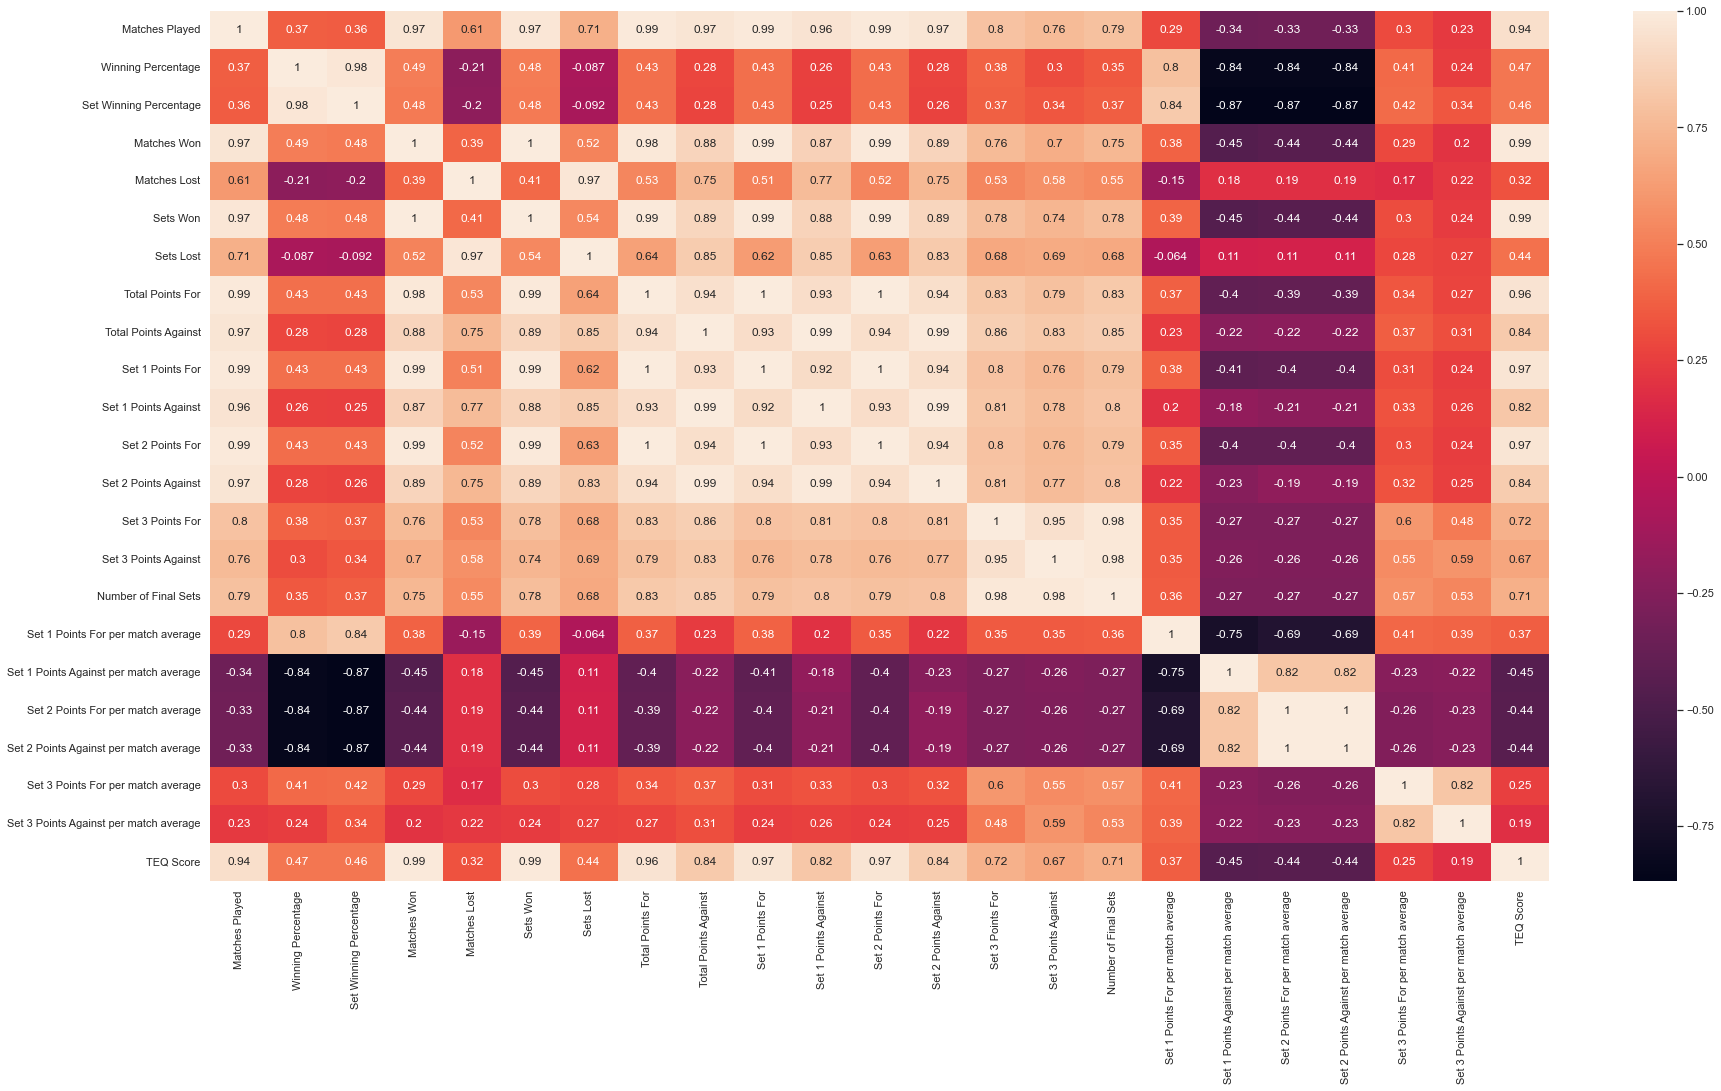

In [67]:
sns.set(rc = {'figure.figsize':(30, 16)})

sns.heatmap(df_doubles_grouped.corr(method='pearson'), annot = True)

In [68]:
## Distribution - histplot

<AxesSubplot:xlabel='Matches Played', ylabel='Count'>

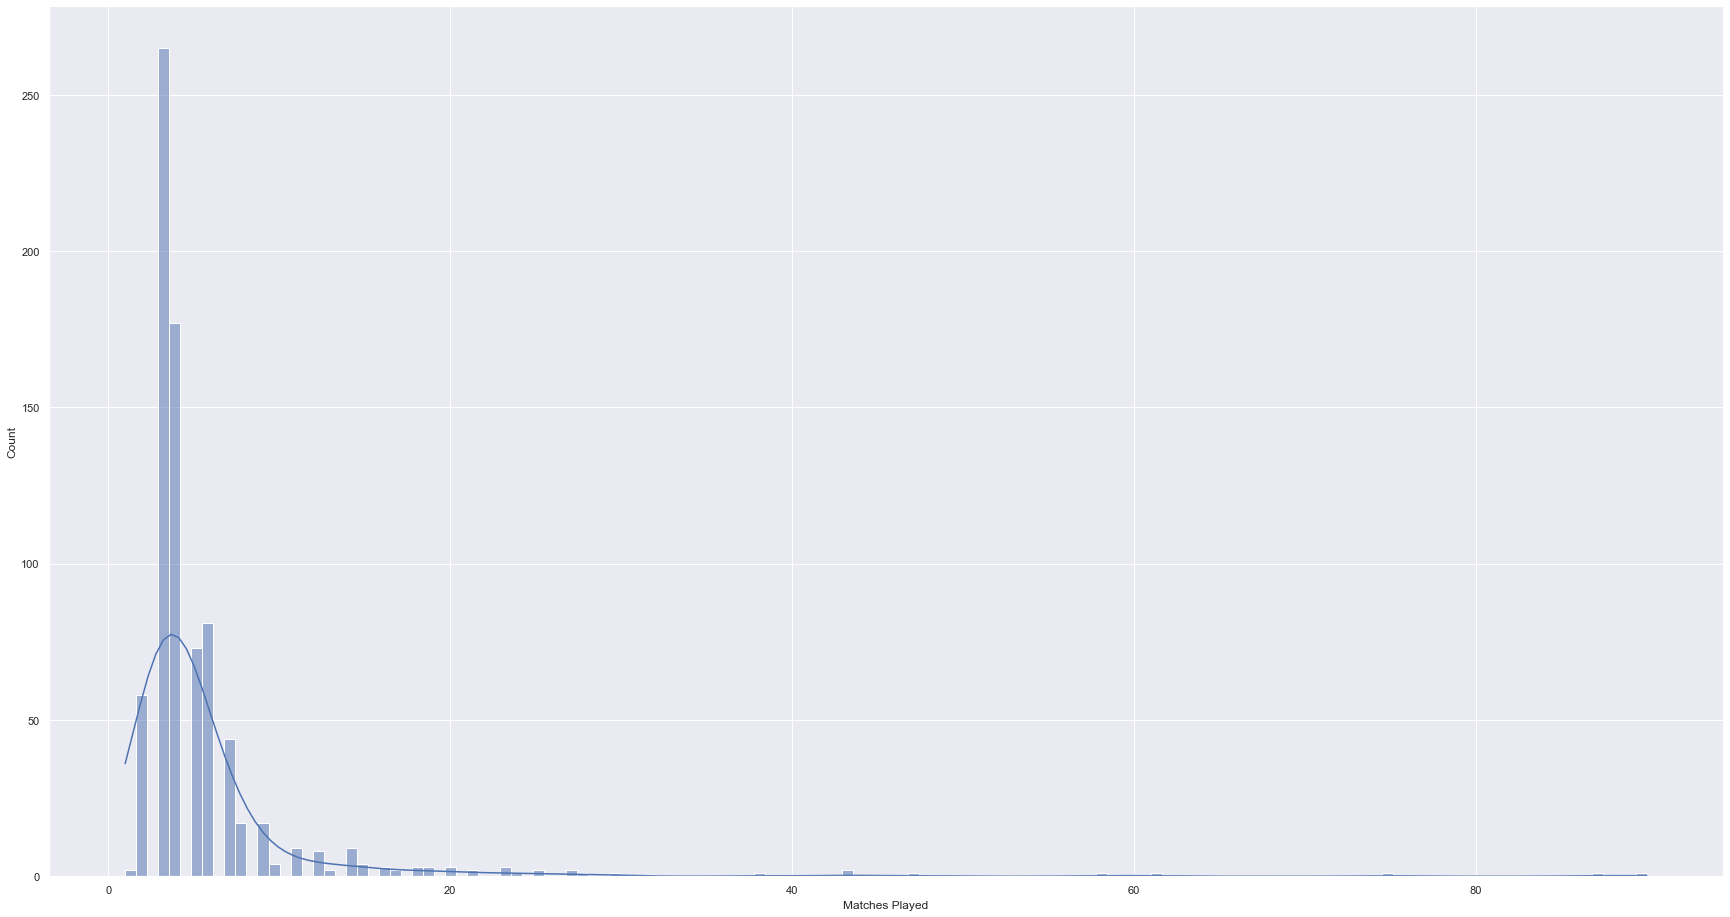

In [69]:
sns.histplot(data=df_doubles_grouped, x="Matches Played", kde=True)

In [70]:
## CREATE SINGLES DATABASE

In [71]:
df1['type'].unique()
df1_singles = df1[df1['type'].isin(['SinglesFree','SinglesMen', 'SinglesWomen'])]

In [72]:
df1_singles.shape

(4571, 22)

In [73]:
df1_singles.columns

Index(['event_name', 'type', 'playerAName', 'associationPlayer_A',
       'playerBName', 'associationPlayer_B', 'playerXName',
       'associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'stage',
       'matchDateTime', 'setsWon_A', 'setsWon_X', 'pointTotal_A',
       'pointTotal_X', 'set1_AB', 'set1_XY', 'set2_AB', 'set2_XY', 'set3_AB',
       'set3_XY'],
      dtype='object')

In [74]:
df1_singles_A = df1_singles.rename(columns = {'playerAName': 'player', 'associationPlayer_A': 'nationality',
       'playerXName': 'opponent',
       'associationPlayer_X':'opponent_nationality', 'setsWon_A': 'setsWonPlayer', 'setsWon_X':'setsLostPlayer', 'pointTotal_A':'pointTotalPlayer',
       'pointTotal_X':'pointTotalOpponent', 'set1_AB':'set1Player', 'set1_XY':'set1Opponent', 'set2_AB':'set2Player', 'set2_XY': 'set2Opponent', 'set3_AB': 'set3Player',
       'set3_XY': 'set3Opponent'})

df1_singles_B = df1_singles.rename(columns = {'playerAName': 'opponent', 'associationPlayer_A': 'opponent_nationality',
       'playerXName': 'player',
       'associationPlayer_X':'nationality', 'setsWon_A': 'setsLostPlayer', 'setsWon_X':'setsWonPlayer', 'pointTotal_A':'pointTotalOpponent',
       'pointTotal_X':'pointTotalPlayer', 'set1_AB':'set1Opponent', 'set1_XY':'set1Player', 'set2_AB':'set2Opponent', 'set2_XY': 'set2Player', 'set3_AB': 'set3Opponent',
       'set3_XY': 'set3Player'})





In [75]:
df_singles = df1_singles_A.append(df1_singles_B)

<ipython-input-75-9e59ad5d6ebc>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_singles = df1_singles_A.append(df1_singles_B)


In [76]:
df_singles.shape

(9142, 22)

In [77]:
df_singles[['set3Player', 'set3Opponent']] = df_singles[['set3Player', 'set3Opponent']].mask((df_singles["set3Player"] == 0) &(df_singles['set3Opponent'] == 0), np.nan)

In [78]:
df_singles['setsplayed'] = df_singles['setsWonPlayer'] + df_singles['setsLostPlayer']

In [79]:
df_singles['set2Player'].replace(21,12, inplace = True)

In [80]:
df_singles[df_singles['player'] == 'Ibrahim Kamara']



,event_name,type,player,nationality,playerBName,associationPlayer_B,opponent,opponent_nationality,playerYName,associationPlayer_Y,...,setsLostPlayer,pointTotalPlayer,pointTotalOpponent,set1Player,set1Opponent,set2Player,set2Opponent,set3Player,set3Opponent,setsplayed
2231,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Ansumana Kanneh,Sierra Leone,,,...,0,24,7,12,3,12,4,NaN,NaN,2
2234,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Amza Bangura,Sierra Leone,,,...,0,33,7,12,3,12,4,NaN,NaN,2
2235,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Ibrahim Sesay,Sierra Leone,,,...,0,24,11,12,7,12,4,NaN,NaN,2
2245,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Abdulai Bangura,Sierra Leone,,,...,0,24,12,12,3,12,9,NaN,NaN,2
2285,Sierra Leone Challenger Series - Round 2,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Samuel Conteh,Sierra Leone,,,...,0,24,18,12,11,12,7,NaN,NaN,2
2288,Sierra Leone Challenger Series - Round 2,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Kadiatu G Kamara,Sierra Leone,,,...,0,24,5,12,2,12,3,NaN,NaN,2
2293,Sierra Leone Challenger Series - Round 2,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Lamranah Bangura,Sierra Leone,,,...,0,24,3,12,2,12,1,NaN,NaN,2
2267,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Musa Sannoh,Sierra Leone,,,...,0,24,10,12,6,12,4,NaN,NaN,2
2268,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Abdulai Bangura,Sierra Leone,,,...,0,24,13,12,4,12,9,NaN,NaN,2
2286,Sierra Leone Challenger Series - Round 2,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Issa Kargbo,Sierra Leone,,,...,0,24,9,12,4,12,5,NaN,NaN,2


In [81]:
df_singles_grouped = df_singles.groupby(['player', 'nationality']).agg({
    'opponent': 'count',
    'setsWonPlayer': 'mean',
    'setsLostPlayer': 'mean',
    'pointTotalPlayer': 'sum',
    'pointTotalOpponent': 'mean',
    'set1Player': 'mean',
    'set1Opponent': 'mean',
    'set2Player': 'mean',
    'set2Opponent': 'mean',
    'set3Player': 'mean',
    'set3Opponent': 'mean',
    'setsplayed': 'sum'
})

In [82]:
df_singles_grouped

,,opponent,setsWonPlayer,setsLostPlayer,pointTotalPlayer,pointTotalOpponent,set1Player,set1Opponent,set2Player,set2Opponent,set3Player,set3Opponent,setsplayed
player,nationality,,,,,,,,,,,,
A Hari Prakash B Ananda Kumar,India,7,1.142857,0.857143,135,18.714286,9.714286,9.285714,9.571429,9.428571,NaN,NaN,14
Aakash Ramachandhiran,India,4,0.250000,2.000000,43,26.250000,4.250000,12.000000,5.000000,11.250000,6.000000,12.000000,9
Abburi Venkata Sai Kiran Abburi Venkatesh,India,8,1.500000,0.750000,190,20.125000,9.750000,9.750000,11.000000,8.875000,12.000000,6.000000,18
Abdelwaly Ferhat,United States,1,0.000000,2.000000,4,24.000000,1.000000,12.000000,3.000000,12.000000,NaN,NaN,2
Abdillahi Mohamed Hassan,Djibouti,10,0.600000,1.400000,150,20.400000,7.800000,10.000000,7.200000,10.400000,NaN,NaN,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zsanett Janicsek,Hungary,45,1.133333,1.022222,898,18.066667,9.244444,8.000000,9.244444,8.688889,9.428571,8.857143,97
Zsofia Dezsenyi,Hungary,9,0.111111,2.000000,97,25.222222,5.555556,11.888889,4.333333,12.000000,8.000000,12.000000,19
Zsolt Lazar,Romania,25,1.600000,0.640000,618,17.400000,11.200000,7.560000,11.000000,7.760000,10.500000,8.666667,56


In [83]:
df_singles_grouped['pointPerSet'] = df_singles_grouped['pointTotalPlayer'] / df_singles_grouped['setsplayed']

In [84]:
df_singles_grouped.sort_values('pointPerSet', ascending = False)['pointPerSet']

player                         nationality  
Ibrahim Kamara                 Sierra Leone     12.136364
Dillion Emeka Nwachukwu        Niger            12.000000
Lino Blute                     Guinea-Bissau    11.900000
Taribo Bhembe                  Eswatini         11.886364
Gamara Da Silva                Guinea-Bissau    11.885714
                                                  ...    
Sali Shenol Sadakov            Bulgaria          1.250000
Mohammad Naser Albaghli        Kuwait            0.800000
Sulaiman Sadeq Hussain Alimir  Kuwait            0.333333
Harison Danny  Tongasoa        Madagascar        0.000000
Aliu Balde                     Guinea-Bissau     0.000000
Name: pointPerSet, Length: 964, dtype: float64

In [85]:
## group by Player A

In [86]:
singles_mean = df1_singles.groupby('playerAName').agg({'setsWon_A': 'mean', 'setsWon_X': 'mean' ,'pointTotal_A': 'mean', 'pointTotal_X': 'mean', 'set1_AB': 'mean', 'set1_XY': 'mean', 'set2_AB': 'mean', 'set2_XY': 'mean', 'set3_AB': 'mean', 'set3_XY': 'mean' }, ).astype(int)

In [87]:
singles_mean.sort_values(by="pointTotal_A", ascending = False)

,setsWon_A,setsWon_X,pointTotal_A,pointTotal_X,set1_AB,set1_XY,set2_AB,set2_XY,set3_AB,set3_XY
playerAName,,,,,,,,,,
Umar Muaz,2,1,38,35,12,8,9,12,17,15
Mario Antonio Carvalho Alves,2,1,38,35,12,10,11,12,15,13
Raja A Sam Rithick Arokiadass,2,1,36,32,12,6,8,12,16,14
Islam Sleiman,2,1,36,31,12,8,11,12,13,11
Martin Yordanov,2,1,35,33,12,11,11,12,12,10
...,...,...,...,...,...,...,...,...,...,...
Abdou Aziz Badji,0,2,4,24,3,12,1,12,0,0
Setranambinina Jaoba Ramanitrarivo,0,2,3,24,1,12,2,12,0,0
Sali Shenol Sadakov,0,2,3,24,1,12,1,12,0,0
